## Analysis of healthy individuals at risk of developing a Mild Cognitive Impairment in 3-5 years

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2, SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, roc_curve, auc, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import NearestNeighbors



In [2]:
# Load dataset
data = pd.read_csv(r'C:\Users\thoma\Code\Projects\Alzheimers Research\Data.csv').astype(float)

### Data Overview

We can start with an overview of the data and by comparing participants who became impaired with those who did not. The main differences appear to be in neuropsychological questionnaires, weight and blood pressure.

In [3]:
# Create new mask variable for patients who developed MCI
mask = data['Impaired'] == 1.000

# Filter data using mask variable
Impaired = data[mask]

# Create mask for patients who did not develop MCI
mask = data['Impaired'] == 0 

# Filter data using mask 
no_Impaired = data[mask]

# New empty DataFrame to display differences
summary = pd.DataFrame() 
summary['Impaired'] = Impaired.mean()
summary['No_Impaired'] = no_Impaired.mean()

summary

,Impaired,No_Impaired
Impaired,1.000000,0.000000
Apoe4,0.346667,0.297297
Gender,1.440000,1.600000
Eth,1.986667,1.962162
Race,4.880000,4.929730
Hand,1.093333,1.086486
Marry,1.360000,1.524324
Home,1.546667,1.454054
Retired,0.813333,0.794595
Occupation,2.933333,2.881081


### Data Preprocessing 

We start by defining our target and predictor variables. 

Next we need to separate our categorical variables into unique columns by one hot encoding. 

The values then need to be displayed as floating point values, where 1.0 indicates presence of variable and 0.0 indicates absense. 


In [4]:
# Create Target Variable y (whether participant develops impairment or not)
y = data['Impaired'].astype(int)

# Create dataset of predictor variables X
X = data.drop(columns=["Impaired"])

# Create continuous and categorical variables
X_categ = X.loc[:,'Apoe4': 'Occupation'].astype(int)
X_cont = X.loc[:, 'Education': 'Resp']

# Convert categorical variables to string to use get_dummies function
X_categ = X_categ.astype(str)

# Convert categorical variables into Dummy Variables.
X_categ_dum = pd.get_dummies(X_categ, columns= None, dtype= int)

# Combine categorical and continuous data into one dataframe
X_processed = pd.concat([X_categ_dum, X_cont], axis=1)

X_processed.head()

,Apoe4_0,Apoe4_1,Apoe4_2,Gender_1,Gender_2,Eth_1,Eth_2,Race_2,Race_4,Race_5,...,NPI,FAQ,Age,Weight,Height,Temp,Systolic,Diastolic,Pulse,Resp
0,1,0,0,1,0,0,1,0,0,1,...,0.0,0.0,86.0,48.0,144.0,97.0,140.0,88.0,60.0,22.0
1,0,1,0,1,0,0,1,0,0,1,...,0.0,0.0,73.0,49.0,180.0,97.0,130.0,70.0,60.0,16.0
2,1,0,0,1,0,0,1,0,0,1,...,0.0,0.0,74.0,50.0,170.0,97.0,112.0,70.0,56.0,12.0
3,1,0,0,1,0,0,1,0,0,1,...,0.0,0.0,79.0,55.0,171.0,98.0,152.0,84.0,66.0,21.0
4,1,0,0,0,1,1,0,0,0,1,...,0.0,0.0,78.0,56.0,145.0,97.0,148.0,72.0,64.0,16.0


## Training_Test split

Then, we can split the dataframe into training and test data. Training data is used to fit the Machine Learning model. On the contrary, test data is used to evaluate the performance or accuracy of the model. It's a sample of data used to make an unbiased evaluation of the final model fit on the training data.

When it comes to splitting data for training and testing in machine learning, a commonly recommended ratio is 80/20 or 70/30. The choice of the split ratio depends on several factors such as the size of the dataset, the complexity of the model, and the specific problem domain. For a smaller dataset 70/30 is more appropriate.

In [5]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.3, stratify= y, random_state= 42)

## SMOTE (Synthetic Minority Over-sampling Technique) 

This is an algorithm used to address the class imbalance problem in machine learning. When datasets have significantly fewer instances of one class compared to others, models can become biased toward the majority class, leading to poor performance in classifying minority class instances. SMOTE helps by generating synthetic examples for the minority class rather than duplicating existing ones.

In [6]:
# Apply SMOTE on the training data
smote = SMOTE(random_state=42)

# Resampled training data 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Standardizing the data 

Many Machine Learning algorithms, as a rule of thumb, benefit from the data being Standardized. For example, Heights might range from 0.5 to 1.5 meters, while weights could range from 5 to 50 kilograms. Without standardizing, the weight might dominate the analysis because its values are larger. 

Standardizing variables follows the equation {z = (x - u) / s} where x is a datapoint, u is the mean of the sample and s is the standard deviation of the sample. 

In [7]:
# Function to standardize the data
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    scaler = StandardScaler() 

    # Apply the scaler to the training and test sets
    train_std=scaler.fit_transform(X_train)

    test_std=scaler.transform(X_test)
    
    return train_std, test_std, scaler

# Standarduze the training and test data
X_train_std, X_test_std, scaler = standardise_data(X_train_resampled, X_test)

In [8]:
# View standardized data in a new dataframe
X_variables = pd.DataFrame(X_train_std, columns= X_processed.columns)

# Get data info 
X_variables.info()

X_variables.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 42 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Apoe4_0       260 non-null    float64
 1   Apoe4_1       260 non-null    float64
 2   Apoe4_2       260 non-null    float64
 3   Gender_1      260 non-null    float64
 4   Gender_2      260 non-null    float64
 5   Eth_1         260 non-null    float64
 6   Eth_2         260 non-null    float64
 7   Race_2        260 non-null    float64
 8   Race_4        260 non-null    float64
 9   Race_5        260 non-null    float64
 10  Race_6        260 non-null    float64
 11  Hand_1        260 non-null    float64
 12  Hand_2        260 non-null    float64
 13  Marry_1       260 non-null    float64
 14  Marry_2       260 non-null    float64
 15  Marry_3       260 non-null    float64
 16  Marry_4       260 non-null    float64
 17  Marry_5       260 non-null    float64
 18  Home_1        260 non-null    

,Apoe4_0,Apoe4_1,Apoe4_2,Gender_1,Gender_2,Eth_1,Eth_2,Race_2,Race_4,Race_5,...,NPI,FAQ,Age,Weight,Height,Temp,Systolic,Diastolic,Pulse,Resp
0,0.803473,-0.517970,-0.108042,-0.777778,1.0,-0.166337,0.2,-0.125,-0.2,0.333333,...,3.369974,1.113096,-1.552772,-1.335299,-0.071375,0.501030,0.956280,-0.519440,-0.618089,-0.208239
1,0.803473,-0.517970,-0.108042,1.285714,-1.0,-0.166337,0.2,-0.125,-0.2,0.333333,...,0.285489,-0.360979,-0.410800,-0.179362,1.084714,0.501030,1.994475,0.933853,1.491285,1.487356
2,-1.244596,1.930615,-0.108042,-0.777778,1.0,-0.166337,0.2,-0.125,-0.2,0.333333,...,1.056610,-0.360979,-0.182405,1.719677,1.084714,1.701497,0.066399,-1.413774,-0.426328,-1.056036
3,-1.244596,1.930615,-0.108042,1.285714,-1.0,-0.166337,0.2,-0.125,-0.2,0.333333,...,-0.485632,-0.360979,0.959567,1.554544,1.820406,1.701497,-0.675169,-2.419900,-1.097492,0.639559
4,0.803473,-0.517970,-0.108042,-0.777778,1.0,-0.166337,0.2,-0.125,-0.2,0.333333,...,-0.485632,-0.360979,0.731172,-1.170165,1.294912,0.501030,-0.156071,-1.860941,0.436598,1.487356


## Visualising the data 

We can visualize the distribution of these variables after standardizing them by looking at histograms. I have created two graphs; one that shows the variables that continue to looked skewed, namely the neuropsychological variables, and the range of other normal looking variables. 

<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

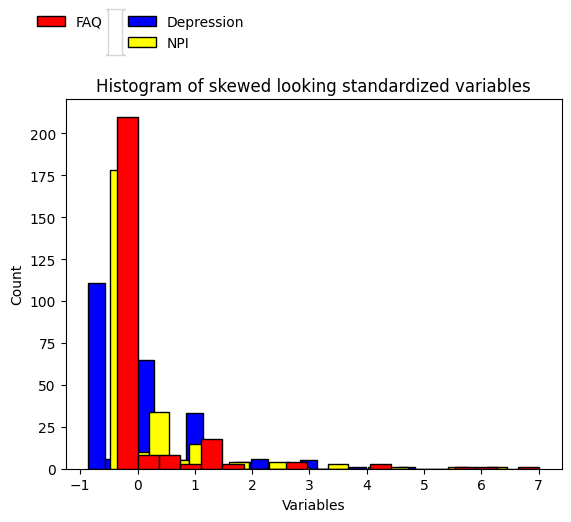

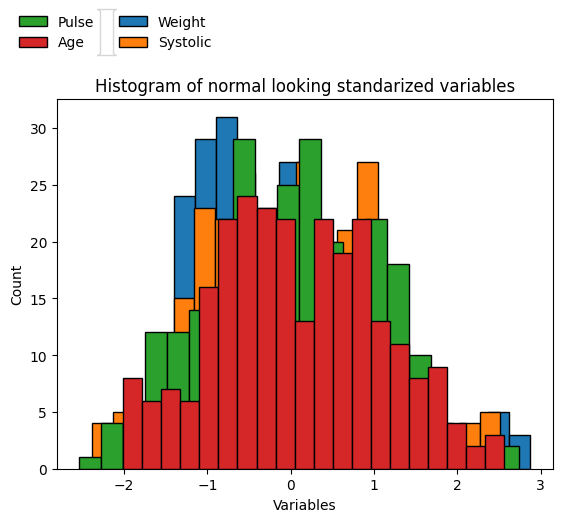

In [9]:
# Draw two figures and prepare graphs
figure, graph = plt.subplots()
figure2, graph2 = plt.subplots()

# Label axis and title of first graph
graph.set_xlabel("Variables")
graph.set_ylabel("Count")
graph.set_title("Histogram of skewed looking standardized variables")

# Label axis and title of second graph
graph2.set_xlabel("Variables")
graph2.set_ylabel("Count")
graph2.set_title("Histogram of normal looking standarized variables")

# Plot histogram of variables that are skewed
graph.hist(X_variables['Depression'], edgecolor='black', bins=20, color= "blue", label = 'Depression') 
graph.hist(X_variables['NPI'], edgecolor='black', bins=20, color = "yellow", label = 'NPI')
graph.hist(X_variables['FAQ'], edgecolor='black', bins=20, color = "red", label = 'FAQ')
graph.legend(bbox_to_anchor=(0.1,1.1), ncol=2, mode='expand', loc='lower left')


# Plot histograms of variables that are normally distributed
graph2.hist(X_variables['Weight'], edgecolor='black', bins=20, label = 'Weight')
#graph2.hist(X_variables['Height'], edgecolor='black', bins=20)
graph2.hist(X_variables['Systolic'], edgecolor='black', bins=20, label = 'Systolic')
#graph2.hist(X_variables['Diastolic'], edgecolor='black', bins=20)
#graph2.hist(X_variables['Resp'], edgecolor='black', bins=20)
graph2.hist(X_variables['Pulse'], edgecolor='black', bins=20, label = 'Pulse')
graph2.hist(X_variables['Age'], edgecolor='black', bins=20, label = 'Age')
graph2.legend(bbox_to_anchor=(0.1,1.1), ncol=2, mode='expand', loc='lower left')

# Show graphs
figure.show
figure2.show



## Logistic Regression

Our baseline will be a Logistic Regression model, which is a well-known supervised Machine Learning algorithm for classification problems.

In [10]:
print(X_train_std.shape)
print(X_test_std.shape)

(260, 42)
(78, 42)


In [11]:
# Create Logistic Regression model 
model = LogisticRegression()

# Tune model on training data
model.fit(X_train_std,y_train_resampled)

# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

# Accuracy of the model
accuracy_train = np.mean(y_pred_train == y_train_resampled)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:.1%}')
print (f'Accuracy of predicting test data = {accuracy_test:.1%}')

Accuracy of predicting training data = 83.8%
Accuracy of predicting test data = 69.2%


The initial accuracy recorded of this model is quite low on both the training and testing datasets. In addition, the accuracy is significantly lower on the testing data, than the training data. This could indicate model overfitting. Overfitting refers to the model capturing higher amount of variance (or noise) from the training data, rather than true relationships, therefore it performs poorer on the unseen training data. 

There are a few things we can do to improve our baseline logistic regression model, such as Feature selection, which we can perform by analysing the model coefficients. 

## Improving the model: Feature Selection

Not all features are equally important. And some may be of little or no use at all, unnecessarily increasing the complexity of the model. 

Here we will look at the importance of features in terms of how they are related to the development of Cognitive Impairment. These are known as the model *coefficients* (if you come from a traditional statistics background), or model *weights* (if you come from a machine learning background). 

With a Logistic Regression model, the coefficients represent how a one-unit increase in the independent variable affects the log odds of the outcome. To interpret it in more practical terms, we can exponentiate the coefficient to get the odds ratio. The odds ratio tells us how the odds of the outcome change for a one-unit increase in the continuous variable.


In [12]:
# Get model coefficients
co_eff = model.coef_[0]

# Store coefficients in a new dataframe 
co_eff_df = pd.DataFrame()

# Get feature names from 
co_eff_df['feature'] = list(X_variables)
co_eff_df['co_eff'] = co_eff
co_eff_df['Odds ratio'] = np.exp(co_eff)
co_eff_df.sort_values(by='Odds ratio', ascending=False, inplace=True)

co_eff_df

,feature,co_eff,Odds ratio
34,Age,0.502745,1.653253
38,Systolic,0.359279,1.432297
33,FAQ,0.336797,1.400455
31,Depression,0.285446,1.330355
36,Height,0.169468,1.184674
32,NPI,0.153494,1.165901
7,Race_2,0.140399,1.150733
40,Pulse,0.110698,1.117058
39,Diastolic,0.083428,1.087007
2,Apoe4_2,0.061459,1.063386


In [13]:
print(co_eff_df['feature'])

34             Age
38        Systolic
33             FAQ
31      Depression
36          Height
32             NPI
7           Race_2
40           Pulse
39       Diastolic
2          Apoe4_2
17         Marry_5
6            Eth_2
37            Temp
8           Race_4
5            Eth_1
30       Education
11          Hand_1
21          Home_4
20          Home_3
9           Race_5
22          Home_5
10          Race_6
12          Hand_2
3         Gender_1
16         Marry_4
41            Resp
23          Home_8
14         Marry_2
19          Home_2
18          Home_1
25       Retired_1
35          Weight
13         Marry_1
15         Marry_3
4         Gender_2
24       Retired_0
1          Apoe4_1
0          Apoe4_0
27    Occupation_2
26    Occupation_1
29    Occupation_4
28    Occupation_3
Name: feature, dtype: object


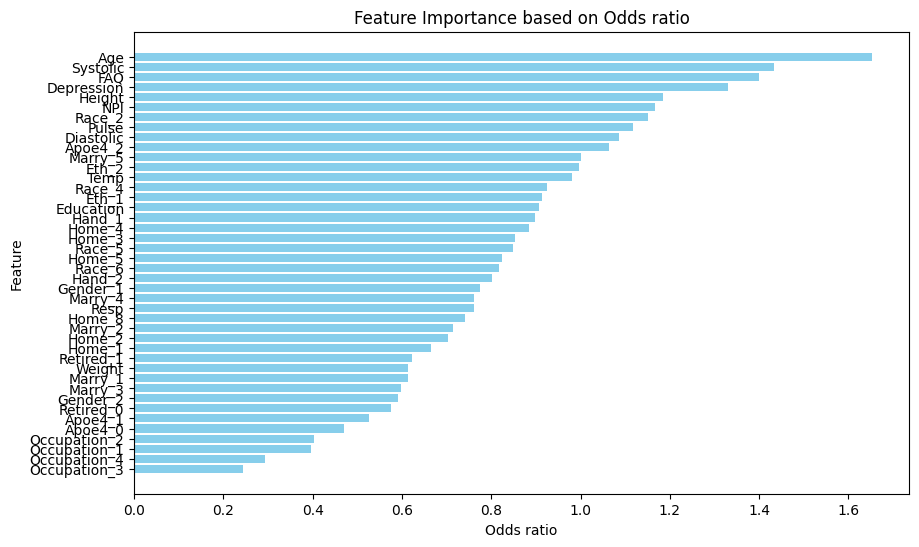

In [14]:
# Sort the dataframe by 'abs_co_eff' for proper ordering in the bar graph
co_eff_df.sort_values(by='Odds ratio', ascending=False, inplace=True)

# Plotting the bar graph to show the feature importance 
plt.figure(figsize=(10, 6))
plt.barh(co_eff_df['feature'], co_eff_df['Odds ratio'], color='skyblue')
plt.xlabel('Odds ratio')
plt.ylabel('Feature')
plt.title('Feature Importance based on Odds ratio')
plt.gca().invert_yaxis()  # To display the largest coefficients at the top
plt.show()


We can run the logistic regression model several times, each time adding another feature, to assess the optimal number of features for model accuracy. 

We have examined the correlation coefficient between each feature and the target variables. This is an example of univariate statistical modelling, as we examined each feature independently.

Two key advantages of this method are its simplicity and speed, however it may miss features which have little effect alone, but which are influential when combined. Also, it does not account for multicollinearity, where independent features are highly correlated and therefore have greater influence on the model, where one should be removed. 

In [15]:
# Create list of ordered features
ordered_features = list(co_eff_df['feature'])

In [16]:
print(ordered_features)

['Age', 'Systolic', 'FAQ', 'Depression', 'Height', 'NPI', 'Race_2', 'Pulse', 'Diastolic', 'Apoe4_2', 'Marry_5', 'Eth_2', 'Temp', 'Race_4', 'Eth_1', 'Education', 'Hand_1', 'Home_4', 'Home_3', 'Race_5', 'Home_5', 'Race_6', 'Hand_2', 'Gender_1', 'Marry_4', 'Resp', 'Home_8', 'Marry_2', 'Home_2', 'Home_1', 'Retired_1', 'Weight', 'Marry_1', 'Marry_3', 'Gender_2', 'Retired_0', 'Apoe4_1', 'Apoe4_0', 'Occupation_2', 'Occupation_1', 'Occupation_4', 'Occupation_3']


In [17]:
# Create list of ordered features
ordered_features = list(co_eff_df['feature'])

# Create list to store accuracies
train_acc_by_feature_number = []
test_acc_by_feature_number = []

# Loop through feature list
number_of_features = len(ordered_features)

for i in range(number_of_features):
    # print ("{0} features of {1}".format(i, number_of_features))
    features_to_use = ordered_features[0:i+1]

    # Get features from original dataset 
    X_selected = X_processed[features_to_use]
 
    # Get training and testing splits
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=42)
    
    # Resample training data using SMOTE
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardize the training and test data
    X_train_std, X_test_std, scaler = standardise_data(X_train_resampled, X_test)
        
    # Set up and fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std,y_train_resampled)

    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    
    # Calculate accuracy of training and testing sets
    accuracy_train = np.mean(y_pred_train == y_train_resampled)
    accuracy_test = np.mean(y_pred_test == y_test)
    
    train_acc_by_feature_number.append(accuracy_train)
    test_acc_by_feature_number.append(accuracy_test)
  

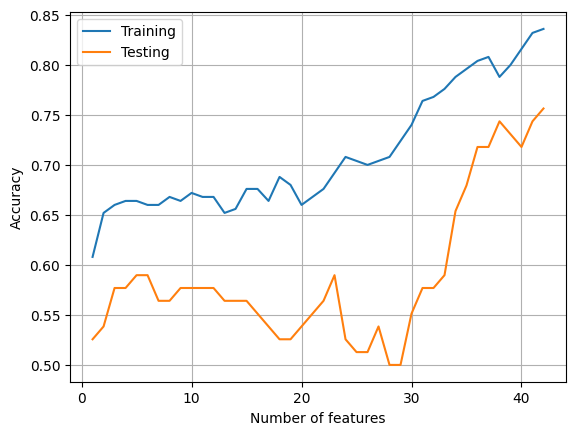

In [18]:
# Create line graph to visualise accuracy by feature 
chart_x = list(range(1, number_of_features + 1))

plt.plot(chart_x, 
        train_acc_by_feature_number,
        label = 'Training')

plt.plot(chart_x, 
         test_acc_by_feature_number, 
         label = 'Testing')

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

We can see from the graph above that there is a general trend of more features = better performance. For our purposes, we will keep the amount of features used to 10. 

In [19]:
# Updated feature cols
feature_cols_10 = ['Age', 'Systolic', 'FAQ', 'Depression', 'Height', 'NPI', 
                   'Race_2', 'Pulse', 'Diastolic', 'Apoe4_2']

In [20]:
# Run the model again with highest 10 features
X_selected_2 = X_processed[feature_cols_10]
                           
# Get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_2, y, test_size=0.3, random_state=42)

# Resample training data using smote
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the training and test data
X_train_std, X_test_std, scaler = standardise_data(X_train_resampled, X_test)
  
# Set up and fit model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_std,y_train_resampled)

# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

# Calculate accuracy of training and testing sets
train_acc = np.mean(y_pred_train == y_train_resampled)
test_acc = np.mean(y_pred_test == y_test)

# Calculate precision and recall of testing data
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score (y_test, y_pred_test)

print('Logistic Regression\n')
print(f'Training accuracy: {train_acc:.1%}')
print(f'Testing data: {test_acc:.1%}')
print(f'Test precision: {test_precision:.1%}')
print(f'Test recall: {test_recall:.1%}')


Logistic Regression

Training accuracy: 67.2%
Testing data: 57.7%
Test precision: 31.7%
Test recall: 72.2%


## Model Performance

--Accuracy is the ratio of correctly predicted instances to the total instances. 

--Precision is the ratio of correctly predicted positive instances to the total predicted positive instances. 

--Recall is the ratio of correctly predicted positive instances to all actual positive instances.

## Confusion Matrix

A confusion matrix is a performance evaluation tool used in classification tasks to visualize the accuracy of a model. It is a table that summarizes the number of correct and incorrect predictions across different classes by comparing the actual labels with the predicted labels.

The matrix consists of four main elements for binary classification:

1. **True Positives (TP)**: Correctly predicted positive cases.
2. **True Negatives (TN)**: Correctly predicted negative cases.
3. **False Positives (FP)**: Incorrectly predicted positive cases (also known as Type I error).
4. **False Negatives (FN)**: Incorrectly predicted negative cases (also known as Type II error).

Depending on our goal, we should pay closer attention to a specific metric. For example, high precision is good when false positives are costly or undesirable (e.g. Spam detection - where marking a legitimate email as spam is problematic). High Recall is better when false negatives are costly or undesirable (e.g. cancer detection - where missing a cancer case is much worse than a false alarm).

In our example, the cost of false negatives is higher and therefore we need to pay closer attention to the recall rate. This figure is low for our Logistic Regression model and therefore problematic.

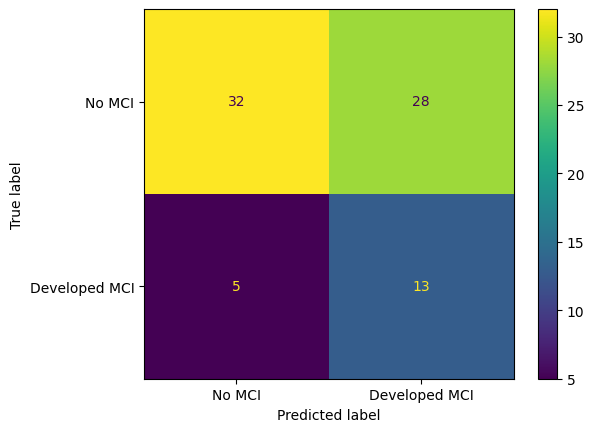

In [21]:
# Display the confusion matrix for the LR model
confusion_matrix_dt = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        y_true = y_test,
        y_pred=y_pred_test,
    ),
    display_labels=['No MCI', 'Developed MCI']
    )

confusion_matrix_dt.plot()

plt.show()

## Receiver Operator Curve (ROC)

The ROC is a graphical assessment of the model's classification performance. It plots the True Positive Rate (proportion of cases correctly identified as positive out of all positive cases; sensitivity) against the False Positive Rate (proportion of cases incorrectly identified as positive out of all negative cases; specificity). For example, a False Positive Rate of 20% would mean that 20% of cases that are negative we would incorrectly classify as being positive.

We plot these rates for varying prediction thresholds. The prediction
threshold is the value above which we classify something as positive (and
below which, something is classified as negative). By default, this is usually
0.5, but that may not always be the best threshold, particularly for imbalanced datasets.

The area under the curve (AUC) provides a single number to summarize the performance 
of the model. It ranges from 0 to 1, where 1 is a perfect classifier, 0.5 is random guessing and < 0.5 performs worse than random guessing. 


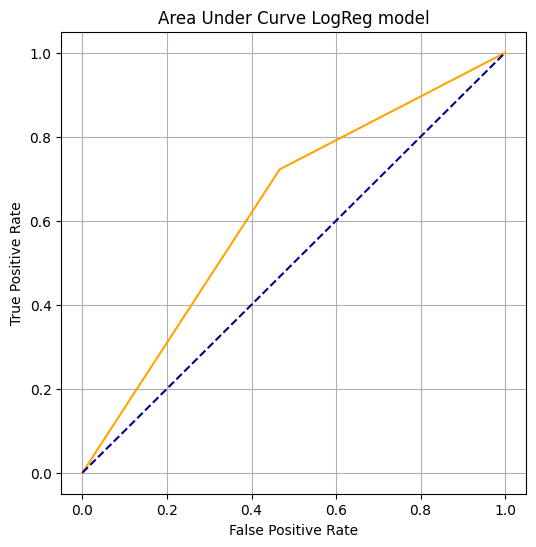

AUC: 0.6277777777777778


In [22]:
# Get fpr, tpr and thresholds fron testing data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the curve 
roc_auc = auc(fpr, tpr)

# Create figure
fig = plt.figure(figsize=(6,6))

# Plot ROC
ax1 = fig.add_subplot()
ax1.plot(fpr, tpr, color= 'orange')
ax1.plot([0,1],[0,1], color='darkblue', linestyle='--')

ax1.set_title('Area Under Curve LogReg model')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
plt.grid(True)
plt.show()

print(f'AUC:',roc_auc)


## Improved Model: XGBooster Algorithm

XGBoost, which stands for “eXtreme Gradient Boosting,” is an advanced implementation of the gradient boosting algorithm. Gradient boosting is a machine learning technique where the main idea is to combine many simple models, also known as “weak learners,” to create an ensemble model that is better at prediction.

In [23]:
# Import xgboost model
from xgboost.sklearn import XGBClassifier

Here I have created a function that takes data array parameters (X, y) and a model to use. The function will perform many tasks, such as training and test split, before showing metrics for model performance. This will make it easier to tune the XG model. 

In [24]:
# Function to prepare data and then run chosen model
def train_and_run_dt(X, y, model):

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

    # Standardize using standard scaler 
    scaler = StandardScaler() 

    # Apply the scaler to the training and test sets
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # Fit 
    model.fit(X_train_std,y_train)
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    accuracy_train = np.mean(y_pred_train == y_train)
    accuracy_test = np.mean(y_pred_test == y_test)

    # Performance of model
    print (f'Accuracy of predicting training data = {accuracy_train:.3f}')
    print (f'Accuracy of predicting test data = {accuracy_test:.3f}')

    print (f'Precision on test data = {precision_score(y_test, y_pred_test):.3f}')
    print (f'Recall on test data = {recall_score(y_test, y_pred_test):.3f}')
    print (f'Specificity on test data = {precision_score(y_test, y_pred_test, pos_label=0):.3f}')
    
    # Print confusion matrix 
    confusion_matrix_dt = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        y_true = y_test, 
        y_pred=y_pred_test
    ),
    display_labels=['No MCI', 'Developed MCI']
    )
    confusion_matrix_dt.plot()
    plt.show()

    # Get fpr, tpr and thresholds fron testing data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

    # Calculate the area under the curve 
    roc_auc = auc(fpr, tpr)

    # Print AUC result
    print(f'AUC:',roc_auc)

    # Create figure
    fig = plt.figure(figsize=(6,6))

    # Plot ROC
    ax1 = fig.add_subplot()
    ax1.plot(fpr, tpr, color= 'orange')
    ax1.plot([0,1],[0,1], color='darkblue', linestyle='--')

    ax1.set_title('Area Under Curve XGBoost model')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

    

    return model, scaler

c:\Users\thoma\anaconda3\envs\ML\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of predicting training data = 1.000
Accuracy of predicting test data = 0.731
Precision on test data = 0.385
Recall on test data = 0.278
Specificity on test data = 0.800


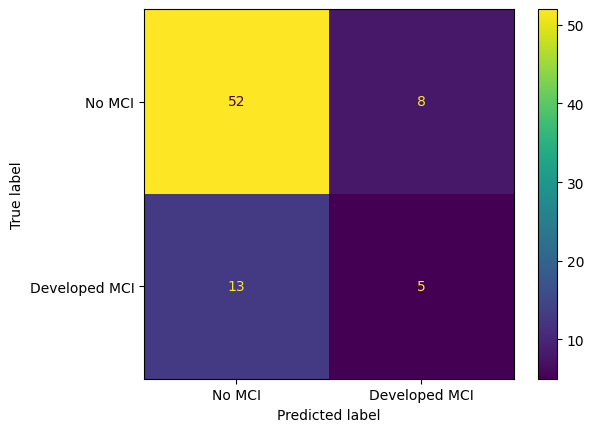

AUC: 0.5722222222222222


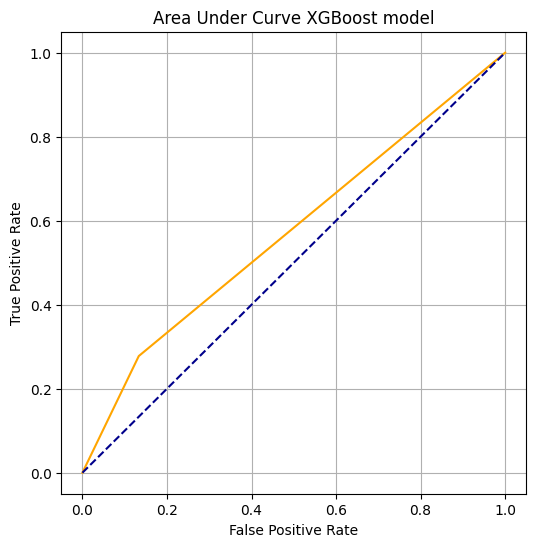

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 StandardScaler())

In [25]:
# Create a baseline XGBClassifier model (before tuning)
XBC_model = XGBClassifier(randomstate=42)

# Run XBG model and return model and standarizing scaler for future 
train_and_run_dt(X_processed, y, XBC_model)

 We can see the baseline model is overfitted (the training data set accuracy is much larger than the testing set). Additionally the precision and recall values are low and could improve. Here we try to tune parameters of the model. 

## Improving the model: Tuning parameters

c:\Users\thoma\anaconda3\envs\ML\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of predicting training data = 0.824
Accuracy of predicting test data = 0.769
Precision on test data = 0.500
Recall on test data = 0.222
Specificity on test data = 0.800


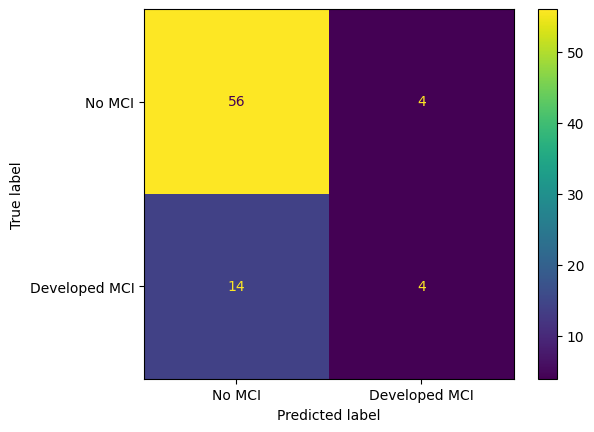

AUC: 0.5777777777777778


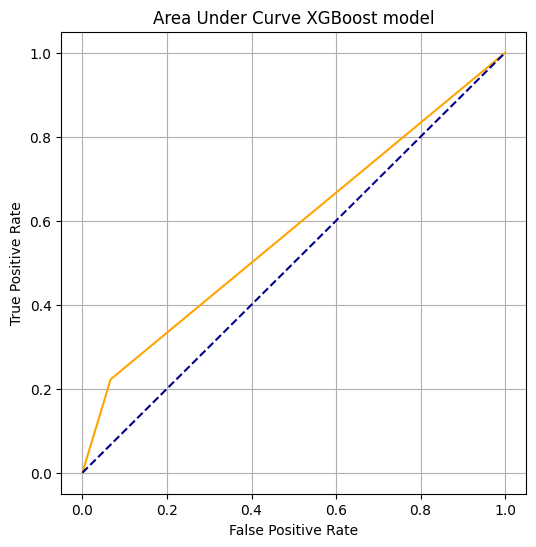

In [26]:
# XBclassifier 
XBC_model_tuned = XGBClassifier(eta = 0.05, max_depth = 2, randomstate=42, tree_method = 'hist', max_bin = 1000)
# Metrics
XBC_tuned, scaler = train_and_run_dt(X_processed, y, XBC_model_tuned)

We have managed to reduce model overfitting and improve the precision value. Unfortunately recall is still low, and this is problematic for healthcare models such as predicting MCI. This is because for 14 people who went onto develop MCI, our model did not predict they would develop a MCI. This is risky. 

One reason for this is because we do not have enough data. A solution is to create synthetic datapoints to increase the amount of data we have to train.

In [27]:
# Re-run code to add back all features (we previous selected 20 using feature 
# selection.

# Get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42)

# Standardize the training and test data
X_train_std, X_test_std, scaler = standardise_data(X_train, X_test)

## Improving model recall: Making more data 

### Function to create synthetic data

This function generates synthetic data for feature (X) and label (y) data in a binary classification problem.  We pass the feature and label data when we call the number of functions, and (optionally) the number of synthetic data points that we want to create for each class.

We first count the number in each class in the data passed into the function.  The SMOTE implementation in the imbalanced-learn library requires us to specify the TOTAL number of data points we will end up with for each class.  This is the total number we already have for each class + the number of synthetic data points we want to create.  In this example, we're only going to use the synthetic data points as we're using them to replace the existing data, rather than augment, but we still have to go through the same process.

We then tell SMOTE to generate some synthetic data points for each class from the original data points using the `fit_resample()` method.

Once the new synthetic data points have been generated, we have two NumPy arrays - one for each class - which contain all the real data points for that class followed by all the synthetic points for that class.

In [28]:
def add_data(X, y, number_of_samples=[1000,1000]):
    
    # Count instances in each class
    count_label_0 = np.sum(y==0)
    count_label_1 = np.sum(y==1)
    
    # SMOTE requires final class counts; add current counts to required counts
    # (which are passed into the function) + 275 more 
    n_class_0 = number_of_samples[0] + count_label_0 
    n_class_1 = number_of_samples[1] + count_label_1 + 275

    # Use SMOTE to sample data points.
    X_synthetic, y_synthetic = SMOTE(
    sampling_strategy = {0:n_class_0, 1:n_class_1}).fit_resample(X, y)
                                                                  
    return X_synthetic, y_synthetic

### Balancing the dataset

If a dataset is 'Imbalanced' this means the number of participants per class is not equally distributed. This can decrease the sensitivity of the model towards minority classes. 

We can check our target variable class balance by looking at the number of participants who remained healthy (0) and those who developed a Mild Cognitive Impairment (1). From this we can see there is an imbalance (larger number of participants who remain unimpaired). This is to be expected, as after 3-5 years we wouldn't expect most of the dataset to become unwell. 

In [29]:
# Get counts of classes from y_train
unique, original_frequency = np.unique(y, return_counts = True)
required_smote_count = list(original_frequency * 3)

print(required_smote_count)

[555, 225]


In [30]:
# Call the function we wrote above to generate and extract the synthetic data
X_synthetic, y_synthetic = add_data(
        X_processed, y, number_of_samples=required_smote_count)

y_synthetic.value_counts()

Impaired
0    740
1    575
Name: count, dtype: int64

In [31]:
# Standardise real and synthetic data (standardise based on data in the real 
# training data)
X_train_std, X_synth_std, scaler = standardise_data(X_train, X_synthetic)

# Get ALL real X data (combine standardised training + test data)
X_real_std = np.concatenate([X_train_std, X_test_std], axis=0)
  
# Use SciKitLearn neighbors.NearestNeighbors to find nearest neighbour
# to each data point.
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_real_std)
dists, idxs = nn.kneighbors(X_synth_std)

# Store the distances and data point ids (indices) in the synthetic DataFrame
# as two new columns.
X_synthetic['distance_to_closest_real'] = list(dists.flatten())
X_synthetic['closest_X_real_row_index'] = list(idxs.flatten())

# Create new dataframe
synth = pd.DataFrame(X_synthetic)

# Add y values to new dataframe
y = list(y_synthetic)
synth['Impaired'] = y

#### Remove identical or close synthetic data

Let's now get rid of any synthetic data points that are "identical" (or effectively identical) to real data points.  You may find you don't have, depending on how SMOTE generated the points (remember, it's random).


We're also going to remove the 10% of points that are closest to the original data.

We'll sort our synthetic data points so that those with the highest distances from the nearest real data point (ie those that we want to keep) are at the top.  Then we can just keep the first 90% of data points (thereby removing the 10% that are the closest).

In [32]:
# Get points ("passengers") that are identical to real ones (use distance of 
# <0.001 as effectively identical)
identical = synth['distance_to_closest_real'] < 0.001

print (f"Proportion of data points identical to real data points =",
       f"{identical.mean():0.3f}")

# Remove synthetic data points considered "identical".
mask = identical == False
synth_df = synth[mask]

# Proportion of points to remove
proportion_to_remove = 0.1

# Sort by distance, with highest distances (those we want to keep) at 
# the top
synth_by_distance = synth.sort_values(
    'distance_to_closest_real', ascending=False)

# Limit data
number_to_keep = int(len(synth_by_distance) * (1 - proportion_to_remove))
synth_by_distance = synth_by_distance.head(number_to_keep)

# Shuffle and store back in synth_df (frac=1 gives us a sample size of 100%
# (ie - all of the ones we said above we wanted to keep))
synth = synth_by_distance.sample(frac=1)

# View synthetic dataset after dropping close values
synth.drop(columns = ['distance_to_closest_real', 'closest_X_real_row_index'])

Proportion of data points identical to real data points = 0.198


,Apoe4_0,Apoe4_1,Apoe4_2,Gender_1,Gender_2,Eth_1,Eth_2,Race_2,Race_4,Race_5,...,FAQ,Age,Weight,Height,Temp,Systolic,Diastolic,Pulse,Resp,Impaired
274,0,1,0,0,0,0,0,0,0,1,...,0.000000,66.640533,75.135110,153.864890,97.786489,121.145956,70.864890,60.145956,14.427022,0
416,0,0,0,0,1,0,1,0,0,1,...,0.000000,75.546303,91.907395,174.134244,98.226849,134.680546,68.185210,60.453697,12.453697,0
929,0,0,0,0,0,0,1,0,0,1,...,0.179654,72.179654,58.898271,175.000000,95.359308,130.898271,77.640692,78.023804,14.718617,1
663,1,0,0,0,0,0,1,0,0,1,...,0.000000,73.000000,89.170677,171.378008,97.603665,128.414662,69.207331,57.585338,17.585338,0
878,0,0,0,0,0,0,1,0,0,1,...,0.423013,72.423013,60.115066,175.000000,95.846027,132.115066,77.153973,75.346854,15.692053,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,0,1,0,0,1,0,1,0,0,1,...,0.000000,72.803476,78.366087,166.535651,98.633913,140.508691,67.803476,75.366087,14.535651,1
445,1,0,0,1,0,0,1,0,0,1,...,1.928168,73.517958,88.517958,176.625706,96.964084,116.748587,79.035916,65.784503,18.071832,0
777,1,0,0,1,0,0,1,0,0,1,...,0.000000,79.000000,82.246916,179.753084,97.811729,143.012336,89.506168,72.811729,15.129626,0
987,0,0,0,0,0,0,1,0,0,1,...,0.000000,69.809080,77.705471,165.456345,98.000000,130.190920,64.323632,75.352736,11.838184,1


c:\Users\thoma\anaconda3\envs\ML\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of predicting training data = 0.861
Accuracy of predicting test data = 0.831
Precision on test data = 0.847
Recall on test data = 0.748
Specificity on test data = 0.821


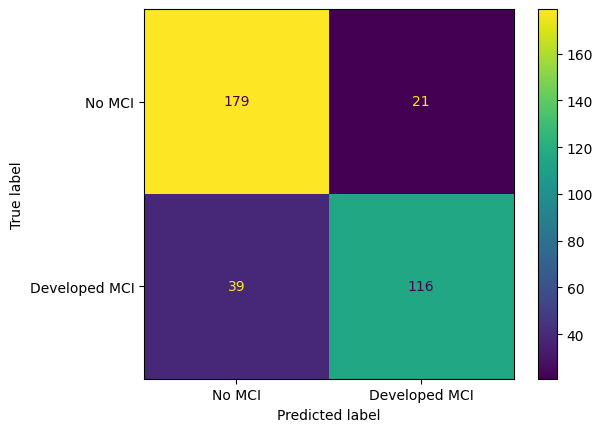

AUC: 0.8216935483870969


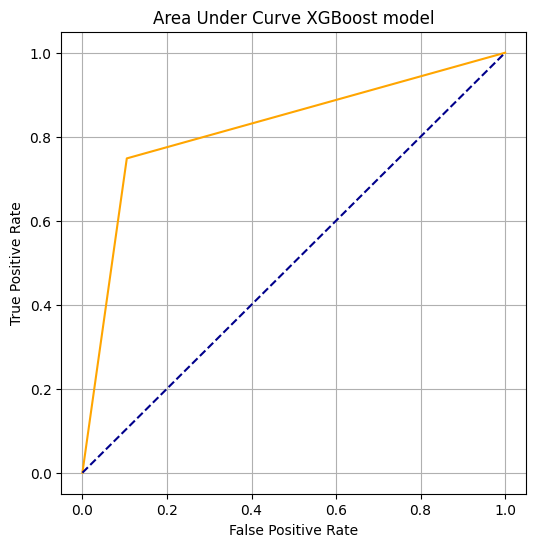

In [33]:
# Create Target Variable y
y = synth['Impaired'].astype(int)

# Create dataset of predictor variables X
X = synth.drop(columns=["Impaired",'distance_to_closest_real', 'closest_X_real_row_index'])

# Re-run XG model with more data 
XBC_model_tuned, XBC_scaler = train_and_run_dt(X, y, XBC_model_tuned)

## Run single datapoint on model to predict MCI 

In [34]:
# Extract a single row and keep it as a DataFrame with shape (1, n_features)
X1 = X_processed.iloc[[24]]

# See datapoint
[print(X1)]

# Apply the standardizing scaler to the single data point (use the scaler that was fitted on the training data)
X1_std = XBC_scaler.transform(X1)

# Run the standardized single data point through the trained model for prediction
prediction = XBC_model_tuned.predict(X1_std)

# Output the prediction
print("\nPrediction for the test data point:", prediction)

    Apoe4_0  Apoe4_1  Apoe4_2  Gender_1  Gender_2  Eth_1  Eth_2  Race_2  \
24        0        1        0         1         0      0      1       0   

    Race_4  Race_5  ...  NPI  FAQ   Age  Weight  Height  Temp  Systolic  \
24       1       0  ...  0.0  0.0  84.0    61.0   163.0  98.0     140.0   

    Diastolic  Pulse  Resp  
24       94.0   83.0  20.0  

[1 rows x 42 columns]

Prediction for the test data point: [1]
